In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [ ]:
# Define the transformation that only converts images to tensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()
])


dataset = ImageFolder(root='../Dataset_BUSI_with_GT/', transform=transform)
loader = DataLoader(dataset, batch_size=50, num_workers=4, shuffle=False)

# Function to calculate mean and std
def get_mean_and_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

mean, std = get_mean_and_std(loader)
print(f'Mean: {mean}')
print(f'Std Dev: {std}')

Mean: tensor([0.3282, 0.3282, 0.3281])
Std Dev: tensor([0.2190, 0.2190, 0.2190])


In [ ]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean, std)  # Normalize images
])

# Load the dataset with the new transformation
dataset = ImageFolder(root='../Dataset_BUSI_with_GT/', transform=transform)


# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class MaskedAutoEncoder(nn.Module):
    def __init__(self):
        super(MaskedAutoEncoder, self).__init__()

        # Encoder
        # Load pre-trained ResNet50 and remove the fully connected layer
        self.encoder = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Remove the fully connected layer and avgpool


        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, output_padding=1),  # (1024, 8, 8)
            nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1),  # (512, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # (256, 32, 32)
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128, 64, 64)
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64, 128, 128)
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=1, padding=1),  # (3, 128, 128)
            nn.Tanh()
        )

    def forward(self, x, mask_ratio=0.75):
        # Apply grid masking
        batch_size, _, H, W = x.shape
        patch_size = 16  # Define the patch size
        num_patches = (H // patch_size) * (W // patch_size)
        num_masked_patches = int(mask_ratio * num_patches)

        mask = torch.ones(batch_size, H // patch_size, W // patch_size, device=x.device)
        for i in range(batch_size):
            mask_indices = torch.randperm(num_patches)[:num_masked_patches]
            mask[i].view(-1)[mask_indices] = 0

        mask = mask.repeat_interleave(patch_size, dim=1).repeat_interleave(patch_size, dim=2)
        mask = mask.unsqueeze(1)  # Add channel dimension

        x_masked = x * mask

        # Encode
        encoded = self.encoder(x_masked)

        # Decode
        decoded = self.decoder(encoded)

        return decoded, mask

In [ ]:
class ResNetClassifier(nn.Module):
    def __init__(self, num_classes=3):  # Assuming 3 classes, change as needed
        super(ResNetClassifier, self).__init__()
        # Load pre-trained ResNet50
        self.encoder = models.resnet50(weights=None)  # Load without pretrained weights initially
        # Replace the fully connected layer
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.encoder(x)

In [ ]:
# Instantiate the model
classifier = ResNetClassifier(num_classes=3)  # Adjust the number of classes as needed
classifier = classifier.to(device)

# Load pre-trained encoder weights
pretrained_model_path = '../masked-auto-encoder/models/mae-grid-masking-resnet50-40.pth'
model = MaskedAutoEncoder()
model.load_state_dict(torch.load(pretrained_model_path, map_location=device))

# Load encoder state dict selectively
encoder_state_dict = model.encoder.state_dict()
model_state_dict = classifier.encoder.state_dict()

# Filter out unnecessary keys
filtered_encoder_state_dict = {k: v for k, v in encoder_state_dict.items() if k in model_state_dict}

# Load the state dictionary
model_state_dict.update(filtered_encoder_state_dict)
classifier.encoder.load_state_dict(model_state_dict)

# Optionally, freeze the encoder layers during initial training
for param in classifier.encoder.parameters():
    param.requires_grad = True

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 181MB/s]


In [ ]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=1e-3)

# Unfreeze the encoder layers for fine-tuning after some initial training epochs
unfreeze_epoch = 5

# Training the classifier
num_epochs = 50
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    if epoch == unfreeze_epoch:
        for param in classifier.encoder.parameters():
            param.requires_grad = True

    classifier.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    classifier.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = classifier(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%")

Epoch [1/50], Train Loss: 0.8721, Val Loss: 1.3457, Train Accuracy: 61.70%, Val Accuracy: 41.67%
Epoch [2/50], Train Loss: 0.7385, Val Loss: 0.9210, Train Accuracy: 68.27%, Val Accuracy: 57.69%
Epoch [3/50], Train Loss: 0.6537, Val Loss: 1.6490, Train Accuracy: 72.92%, Val Accuracy: 57.69%
Epoch [4/50], Train Loss: 0.7010, Val Loss: 1.1330, Train Accuracy: 70.83%, Val Accuracy: 65.38%
Epoch [5/50], Train Loss: 0.6084, Val Loss: 1.1406, Train Accuracy: 75.32%, Val Accuracy: 63.46%
Epoch [6/50], Train Loss: 0.4823, Val Loss: 0.8888, Train Accuracy: 79.97%, Val Accuracy: 71.15%
Epoch [7/50], Train Loss: 0.4418, Val Loss: 1.7099, Train Accuracy: 80.13%, Val Accuracy: 66.67%
Epoch [8/50], Train Loss: 0.5601, Val Loss: 1.3688, Train Accuracy: 78.37%, Val Accuracy: 65.38%
Epoch [9/50], Train Loss: 0.4740, Val Loss: 1.9129, Train Accuracy: 81.73%, Val Accuracy: 69.87%
Epoch [10/50], Train Loss: 0.3304, Val Loss: 0.8538, Train Accuracy: 87.02%, Val Accuracy: 68.59%
Epoch [11/50], Train Loss: 0.

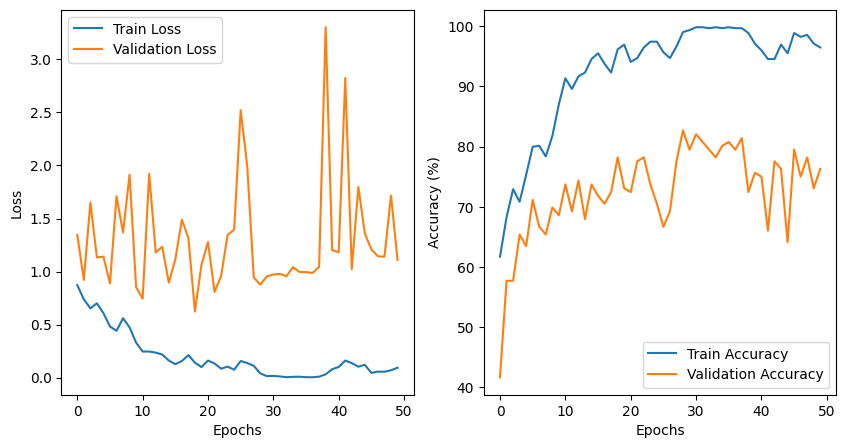

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
# Save the trained classifier model
torch.save(classifier.state_dict(), './models/resnet_classifier_busi.pth')
print('Classifier model saved to ./models/resnet_classifier_busi.pth')

Classifier model saved to /content/drive/MyDrive/LU_ML MS thesis/Project/resnet_classifier_busi.pth
